1. Préparation des données et augmentation

In [ ]:
# Importations nécessaires
from google.colab import drive
import os
import zipfile
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt # Added import
import matplotlib.image as mpimg # Added import

In [ ]:
# 1. Monter Google Drive
drive.mount('/content/drive')

# 2. Définir les chemins
drive_zip_path = '/content/drive/MyDrive/Dogs vs Cats.zip'  # Chemin dans Drive
extract_path = '/content/cats_and_dogs'
original_train_dir = os.path.join(extract_path, 'train/train')  # Adapté à la structure réelle
processed_train_dir = os.path.join(extract_path, 'processed_train')
validation_dir = os.path.join(extract_path, 'validation')

# 3. Nettoyage initial et création des dossiers
!rm -rf {extract_path}  # Suppression complète avant extraction
os.makedirs(extract_path, exist_ok=True)

# 4. Copie depuis Drive vers Colab
!cp "{drive_zip_path}" "{extract_path}/Dogs_vs_Cats.zip"

# 5. Extraction
with zipfile.ZipFile(os.path.join(extract_path, 'Dogs_vs_Cats.zip'), 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 6. Vérification de la structure
print("Structure après extraction:")
!find {extract_path} -type d | sort
print("\nContenu du dossier train/train:")
!ls -la {original_train_dir} | head -10

# 7. Fonction pour organiser les fichiers
def organize_images(source_dir, train_dest, val_dest, test_size=0.2):
    """Organise les images en train/validation avec séparation par classe"""
    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(val_dest, exist_ok=True)

    # Créer sous-dossiers cats/dogs
    for folder in [train_dest, val_dest]:
        for class_name in ['cats', 'dogs']:
            os.makedirs(os.path.join(folder, class_name), exist_ok=True)

    # Lister les fichiers images
    all_files = [f for f in os.listdir(source_dir)
                if os.path.isfile(os.path.join(source_dir, f))
                and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not all_files:
        raise ValueError(f"Aucune image trouvée dans {source_dir}")

    # Séparation train/validation
    train_files, val_files = train_test_split(all_files, test_size=test_size, random_state=42)

    # Déplacement des fichiers
    for file_list, dest in [(train_files, train_dest), (val_files, val_dest)]:
        for file in file_list:
            src = os.path.join(source_dir, file)
            class_folder = 'cats' if 'cat' in file.lower() else 'dogs'
            dst = os.path.join(dest, class_folder, file)
            shutil.move(src, dst)

# 8. Organiser les images
organize_images(
    source_dir=original_train_dir,
    train_dest=processed_train_dir,
    val_dest=validation_dir,
    test_size=0.2
)

# 9. Vérification après organisation
print("\nStructure après organisation:")
!find {extract_path} -type d | sort
print("\nContenu de processed_train:")
!ls -la {processed_train_dir} | head -10
print("\nContenu de validation:")
!ls -la {validation_dir} | head -10

# 10. Paramètres des images
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32
EPOCHS = 15

# 11. Augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# 12. Création des générateurs
train_generator = train_datagen.flow_from_directory(
    processed_train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# 13. Affichage des informations
print("\nClasses d'entraînement:", train_generator.class_indices)
print("Nombre d'images d'entraînement:", train_generator.samples)
print("Nombre d'images de validation:", validation_generator.samples)

Mounted at /content/drive
Structure après extraction:
/content/cats_and_dogs
/content/cats_and_dogs/test
/content/cats_and_dogs/test/test
/content/cats_and_dogs/train
/content/cats_and_dogs/train/train

Contenu du dossier train/train:
total 609280
drwxr-xr-x 2 root root 786432 Jul 11 09:24 .
drwxr-xr-x 3 root root   4096 Jul 11 09:24 ..
-rw-r--r-- 1 root root  12414 Jul 11 09:24 cat.0.jpg
-rw-r--r-- 1 root root  21944 Jul 11 09:24 cat.10000.jpg
-rw-r--r-- 1 root root  27322 Jul 11 09:24 cat.10001.jpg
-rw-r--r-- 1 root root  25723 Jul 11 09:24 cat.10002.jpg
-rw-r--r-- 1 root root  28035 Jul 11 09:24 cat.10003.jpg
-rw-r--r-- 1 root root  12973 Jul 11 09:24 cat.10004.jpg
-rw-r--r-- 1 root root   8245 Jul 11 09:24 cat.10005.jpg

Structure après organisation:
/content/cats_and_dogs
/content/cats_and_dogs/processed_train
/content/cats_and_dogs/processed_train/cats
/content/cats_and_dogs/processed_train/dogs
/content/cats_and_dogs/test
/content/cats_and_dogs/test/test
/content/cats_and_dogs/t

2. Construction du modèle CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

3. Entraînement du modèle

In [ ]:
epochs = 15

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5407 - loss: 0.7205

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 237ms/step - accuracy: 0.5408 - loss: 0.7204 - val_accuracy: 0.6713 - val_loss: 0.6230
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 234ms/step - accuracy: 0.6495 - loss: 0.6202 - val_accuracy: 0.7214 - val_loss: 0.5429
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 233ms/step - accuracy: 0.6904 - loss: 0.5777 - val_accuracy: 0.7550 - val_loss: 0.5076
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.7104 - loss: 0.5533 - val_accuracy: 0.7710 - val_loss: 0.4782
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 328ms/step - accuracy: 0.7417 - loss: 0.5256 - val_accuracy: 0.7913 - val_loss: 0.4489
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 207s 240ms/step - accuracy: 0.7347 - loss: 0.5238 - val_accuracy: 0.7945 - val_loss: 0.4557
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 237ms/step - accuracy: 0.7557 - loss: 0.4926 - val_accuracy: 0.8137 - val_loss: 0.4175
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 237ms/step - accuracy: 0.7742 - loss: 0.47

4. Évaluation du modèle

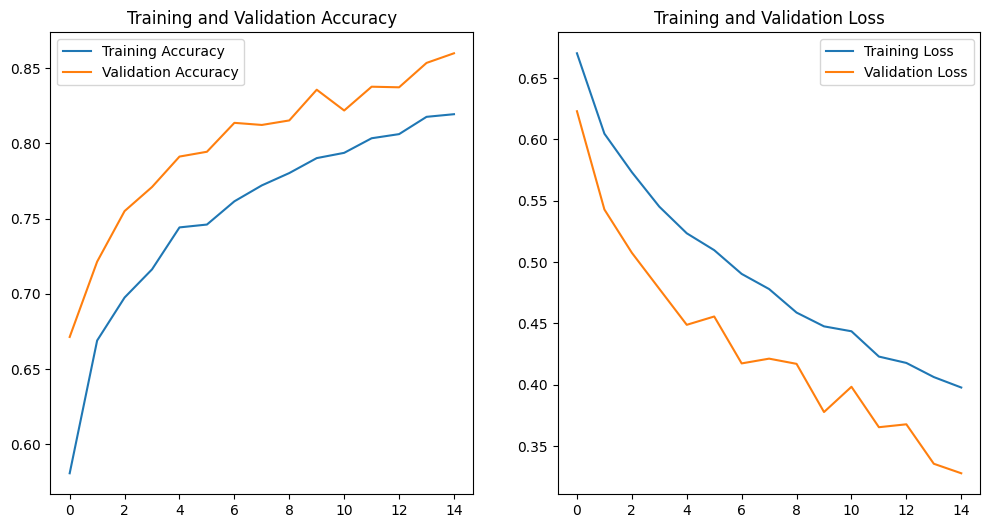

In [ ]:
# Visualisation des courbes d'apprentissage
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

5. Bonus: Visualisation de l'augmentation des données

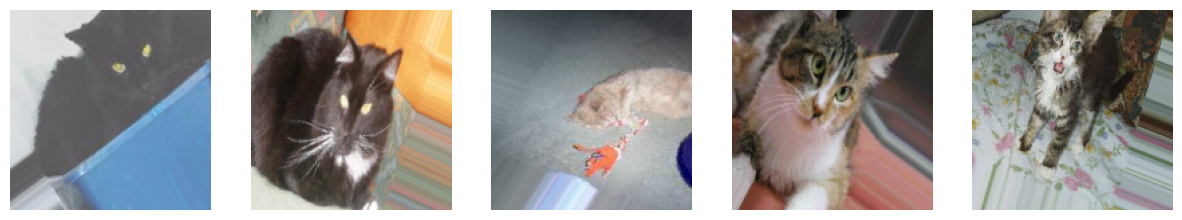

In [12]:
# Fonction pour visualiser des images augmentées
def plot_augmented_images(image_generator, n_images=5):
    # Check if generator is empty
    if len(image_generator) == 0:
        print("The image generator is empty.")
        return

    # Get a batch of images
    # Use __next__() to get a batch from the DirectoryIterator
    batch = image_generator.__next__()
    augmented_images = batch[0][:n_images] # Take up to n_images from the batch

    plt.figure(figsize=(15, 3))
    for i in range(min(n_images, len(augmented_images))): # Ensure we don't exceed the number of images in the batch
        plt.subplot(1, n_images, i+1)
        plt.imshow(augmented_images[i])
        plt.axis('off')
    plt.show()

# Exemple avec le générateur d'entraînement
plot_augmented_images(train_generator) # Corrected variable name